# Parsing xml masks

Binary masks in the Kumar dataset are given in xml format that encodes all the vertices of the annotated cells. This notebook parses the xml-masks and converts them to binary images.

In [15]:
# https://github.com/vqdang/hover_net/blob/master/src/misc/proc_kumar_ann.py
##
## For processing .xml annotation file in Kumar dataset
##
from skimage import draw
import matplotlib.pyplot as plt
import ipywidgets as widgets
import glob
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import scipy.io


###
imgs_dir = "../../../datasets/Nucleisegmentation-Kumar/train/Images/" # .png
anns_dir = "../../../datasets/Nucleisegmentation-Kumar/train/Annotations_xml/" # .xml folders
save_dir = "../../../datasets/Nucleisegmentation-Kumar/train/Labels/" # storing .png ground truth (HW)

file_list = glob.glob(imgs_dir + '*.png')
file_list.sort() # ensure same order [1]

for filename in file_list: # png for base
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]

    print(basename)
    img = cv2.imread(imgs_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hw = img.shape[:2]

    xml = ET.parse(anns_dir + basename + '.xml')

    contour_dbg = np.zeros(hw, np.uint8)

    insts_list = []
    for idx, region_xml in enumerate(xml.findall('.//Region')):
        vertices = []
        for vertex_xml in region_xml.findall('.//Vertex'):
            attrib = vertex_xml.attrib
            vertices.append([float(attrib['X']), 
                             float(attrib['Y'])])
        vertices = np.array(vertices) + 0.5
        vertices = vertices.astype('int32')
        contour_blb = np.zeros(hw, np.uint8)
        
        # fill both the inner area and contour with idx+1 color
        cv2.drawContours(contour_blb, [vertices], 0, idx+1, -1)
        insts_list.append(contour_blb)

    insts_size_list = np.array(insts_list)
    insts_size_list = np.sum(insts_size_list, axis=(1 , 2))
    insts_size_list = list(insts_size_list)

    pair_insts_list = zip(insts_list, insts_size_list)
    
    # sort in z-axis basing on size, larger on top
    pair_insts_list = sorted(pair_insts_list, key=lambda x: x[1])
    insts_list, insts_size_list = zip(*pair_insts_list)

    ann = np.zeros(hw, np.int32)
    for idx, inst_map in enumerate(insts_list):
        ann[inst_map > 0] = idx + 1

    mask_fn = save_dir+'/'+basename+'_mask.mat'
    scipy.io.savemat(mask_fn, mdict={'inst_map': ann})

TCGA-18-5592-01Z-00-DX1
TCGA-21-5784-01Z-00-DX1
TCGA-21-5786-01Z-00-DX1
TCGA-38-6178-01Z-00-DX1
TCGA-49-4488-01Z-00-DX1
TCGA-50-5931-01Z-00-DX1
TCGA-A7-A13E-01Z-00-DX1
TCGA-A7-A13F-01Z-00-DX1
TCGA-AR-A1AK-01Z-00-DX1
TCGA-AR-A1AS-01Z-00-DX1
TCGA-AY-A8YK-01A-01-TS1
TCGA-B0-5698-01Z-00-DX1
TCGA-B0-5710-01Z-00-DX1
TCGA-B0-5711-01Z-00-DX1
TCGA-CH-5767-01Z-00-DX1
TCGA-DK-A2I6-01A-01-TS1
TCGA-E2-A14V-01Z-00-DX1
TCGA-E2-A1B5-01Z-00-DX1
TCGA-G2-A2EK-01A-02-TSB
TCGA-G9-6336-01Z-00-DX1
TCGA-G9-6348-01Z-00-DX1
TCGA-G9-6356-01Z-00-DX1
TCGA-G9-6362-01Z-00-DX1
TCGA-G9-6363-01Z-00-DX1
TCGA-HE-7128-01Z-00-DX1
TCGA-HE-7129-01Z-00-DX1
TCGA-HE-7130-01Z-00-DX1
TCGA-KB-A93J-01A-01-TS1
TCGA-NH-A8F7-01A-01-TS1
TCGA-RD-A8N9-01A-01-TS1


# Check that the masks look correct

/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Tissue_images/
/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/
(1000, 1000, 3)
(1000, 1000)


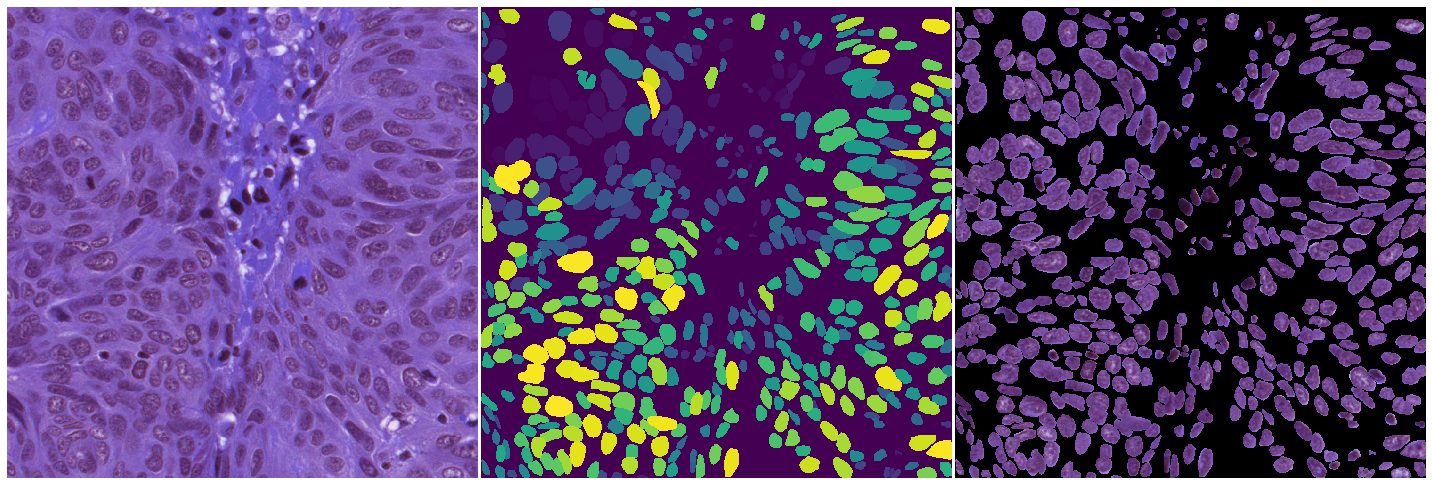

In [16]:
# Superimpose a mask onto the original to check
img = cv2.imread(imgs_dir + "TCGA-18-5592-01Z-00-DX1.png")
mask = scipy.io.loadmat(save_dir + "TCGA-18-5592-01Z-00-DX1_mask.mat")
mask = mask['inst_map']
image_overlayed = np.where(mask[..., None], img, 0)

plt.subplots(1, 3 ,figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img, interpolation='none')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, interpolation='none')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(image_overlayed, interpolation='none')
plt.axis('off')
plt.tight_layout(w_pad=0.3, h_pad=0.3)